In [ ]:
!pip install numpy matplotlib pandas scipy scikit-learn seaborn plotly tensorflow keras fastapi uvicorn requests mysql

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from scipy.stats import skew, kurtosis
from scipy.optimize import differential_evolution, minimize

In [5]:
data = pd.read_csv('multi_sensor_simulated_sound_data.csv')

In [ ]:
# Separate the data by sensor
sensor1_data = data[data['Sensor'] == 'Sensor1']
sensor2_data = data[data['Sensor'] == 'Sensor2']
sensor3_data = data[data['Sensor'] == 'Sensor3']
sensor4_data = data[data['Sensor'] == 'Sensor4']

# Combine data for all sensors into a single DataFrame with separate columns for each sensor's amplitude
combined_data = pd.DataFrame({
    'Angle': sensor1_data['Angle'].reset_index(drop=True),  # Use Angle as the reference
    'Sensor1_Amplitude': sensor1_data['Amplitude'].reset_index(drop=True),
    'Sensor2_Amplitude': sensor2_data['Amplitude'].reset_index(drop=True),
    'Sensor3_Amplitude': sensor3_data['Amplitude'].reset_index(drop=True),
    'Sensor4_Amplitude': sensor4_data['Amplitude'].reset_index(drop=True)
})

(1543500, 5)

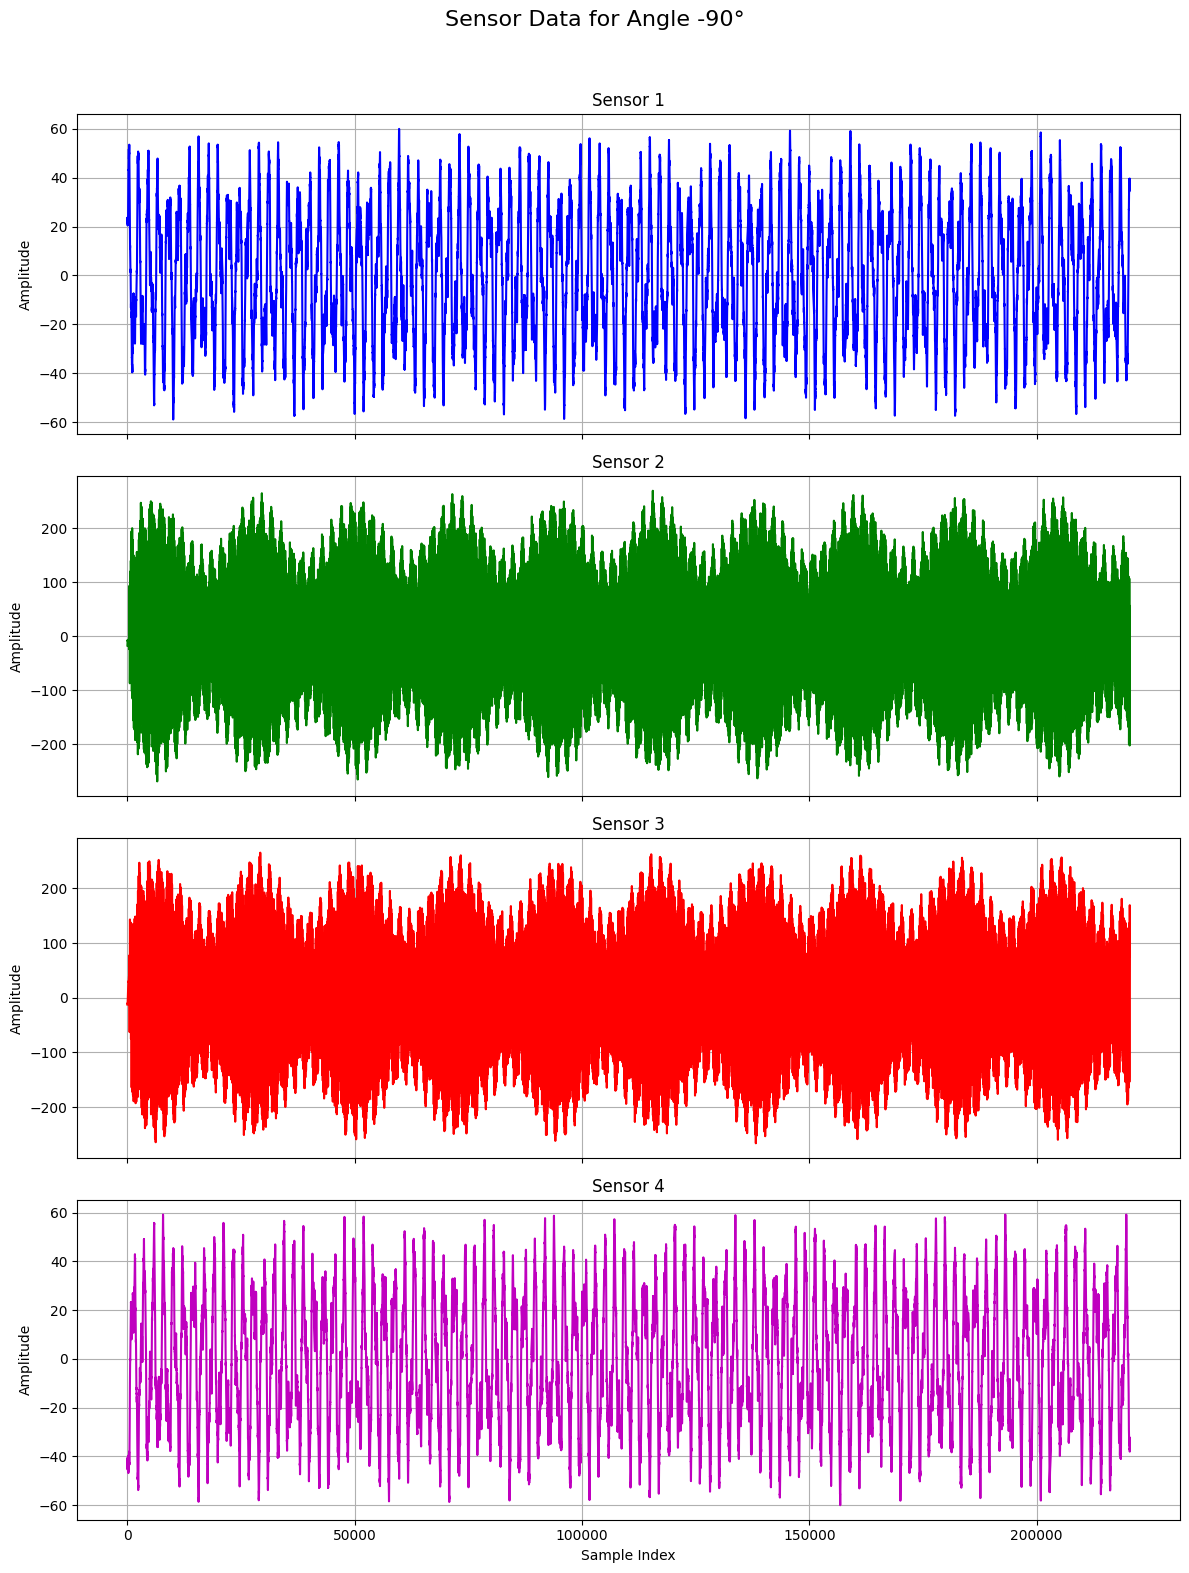

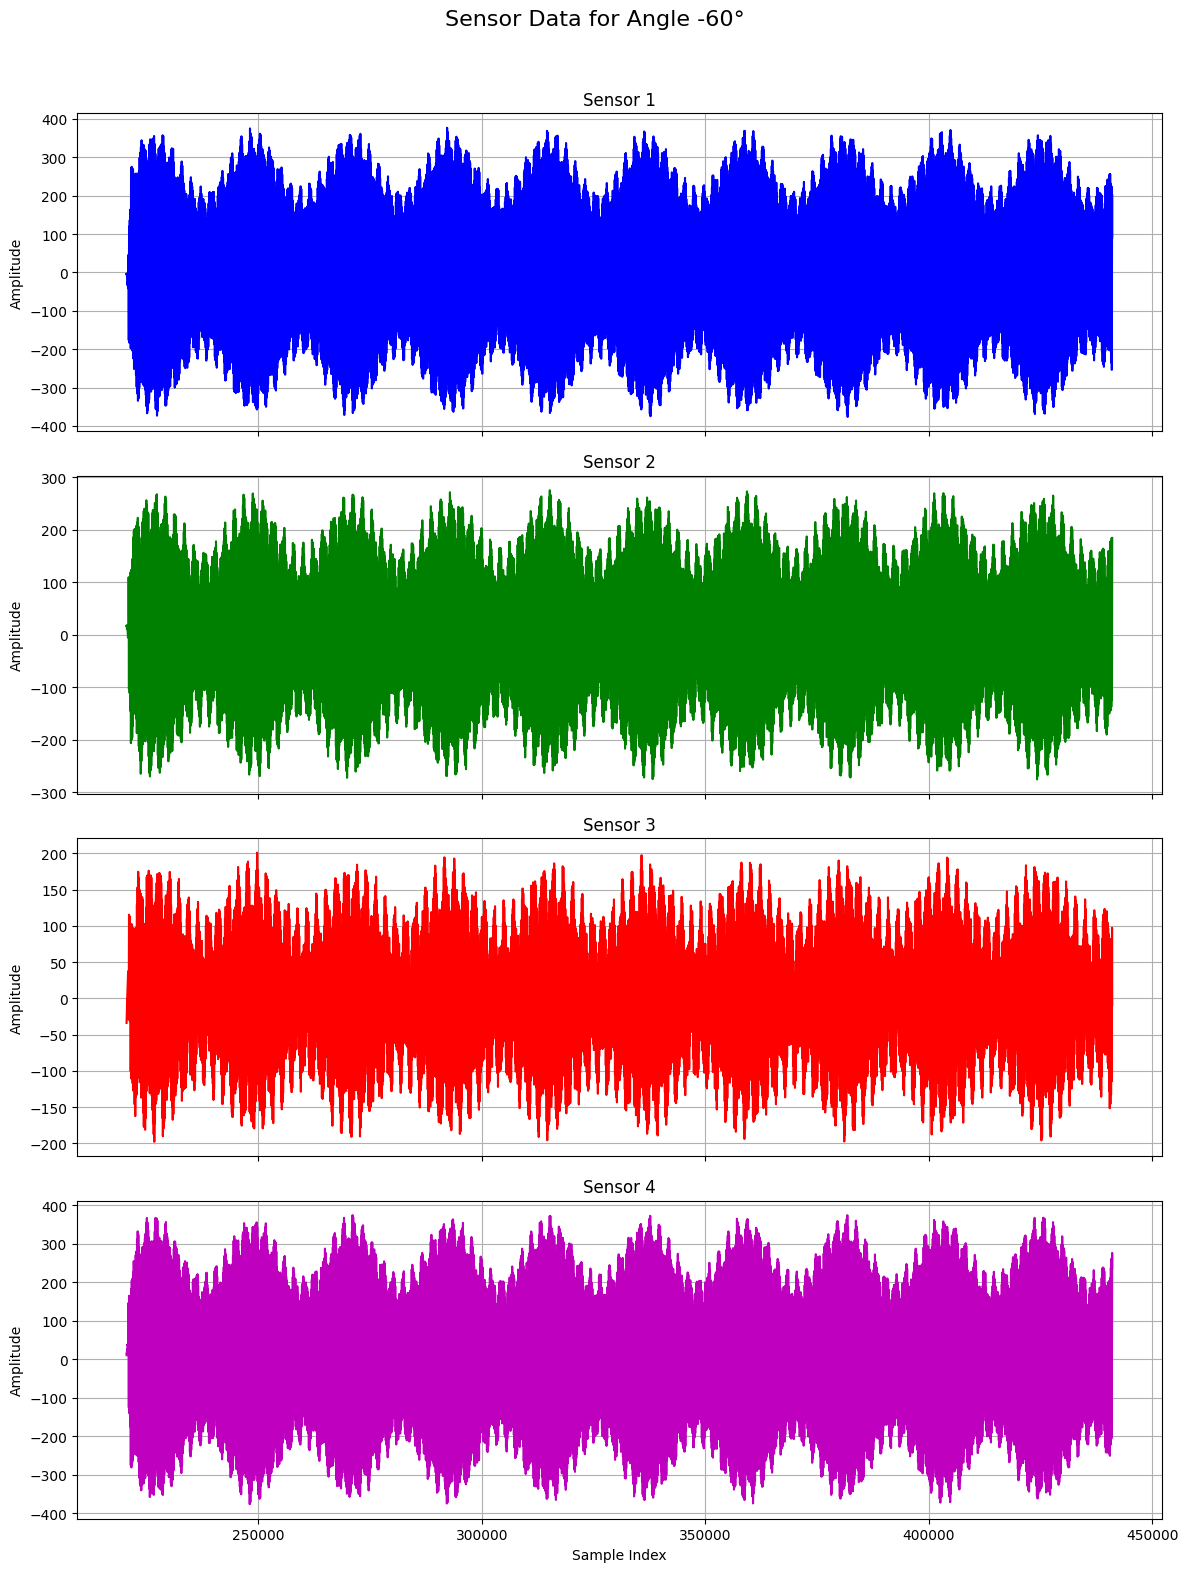

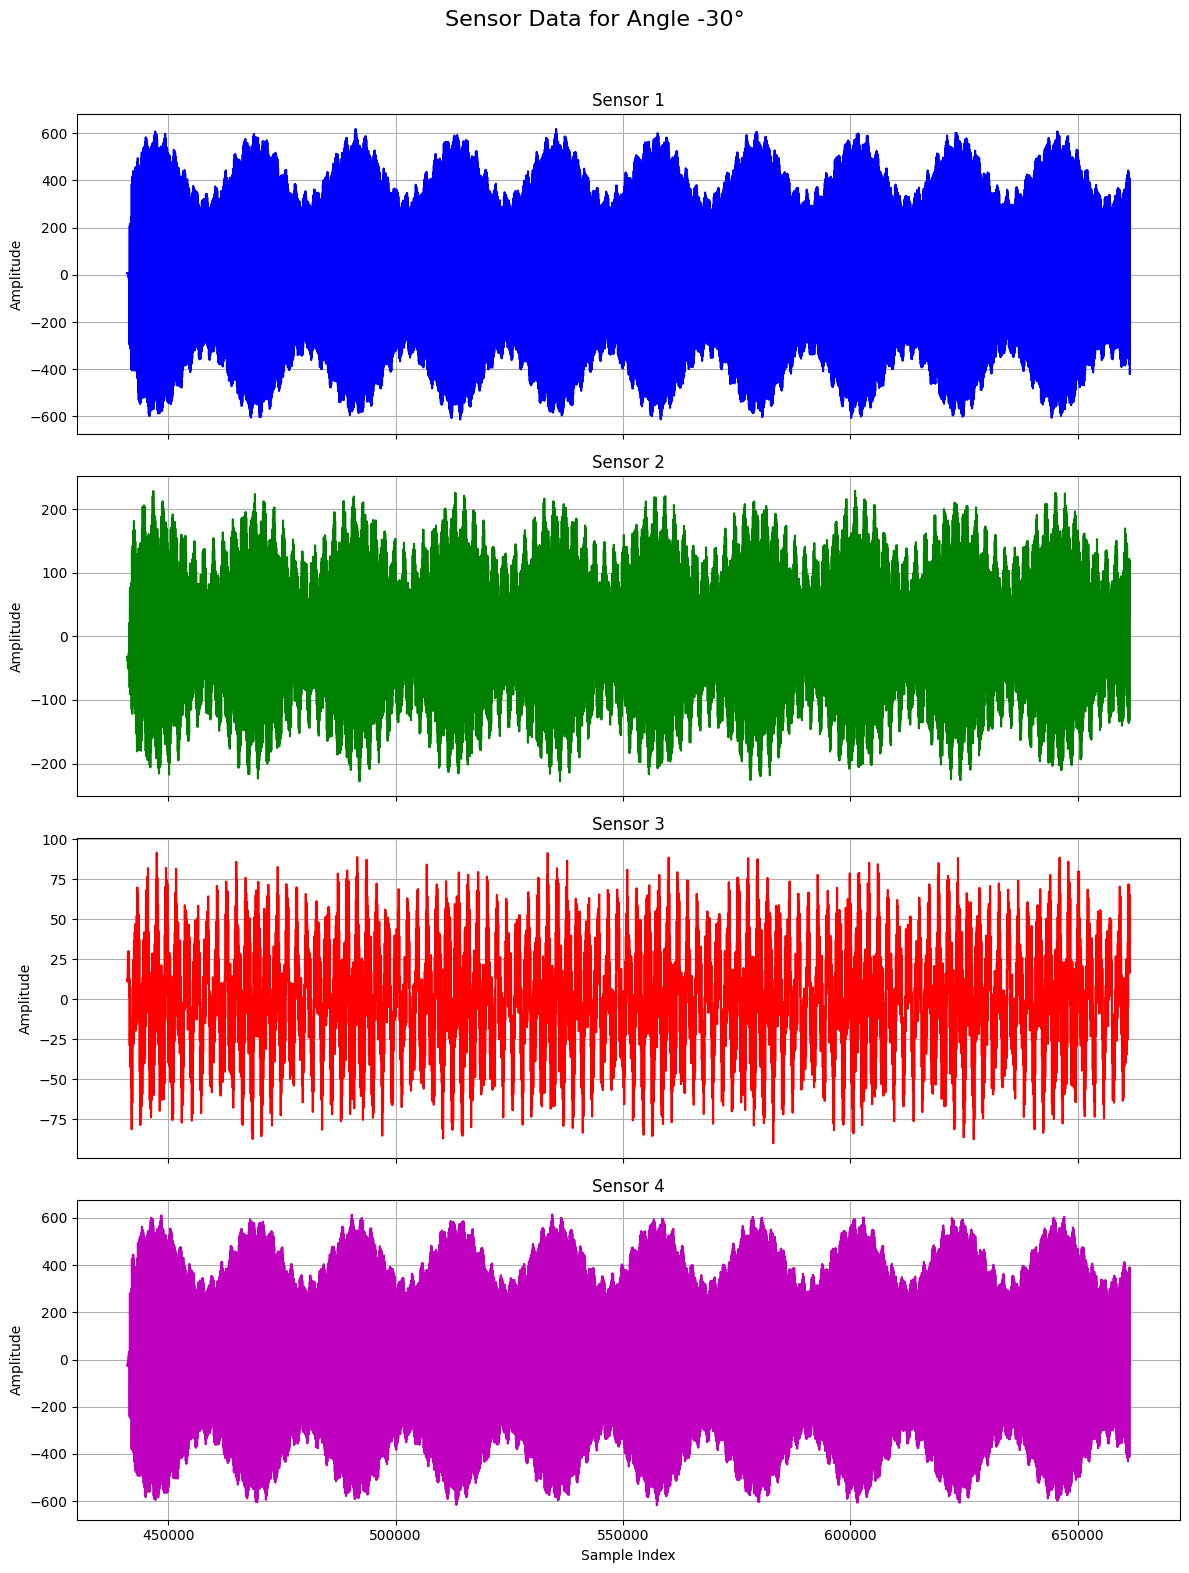

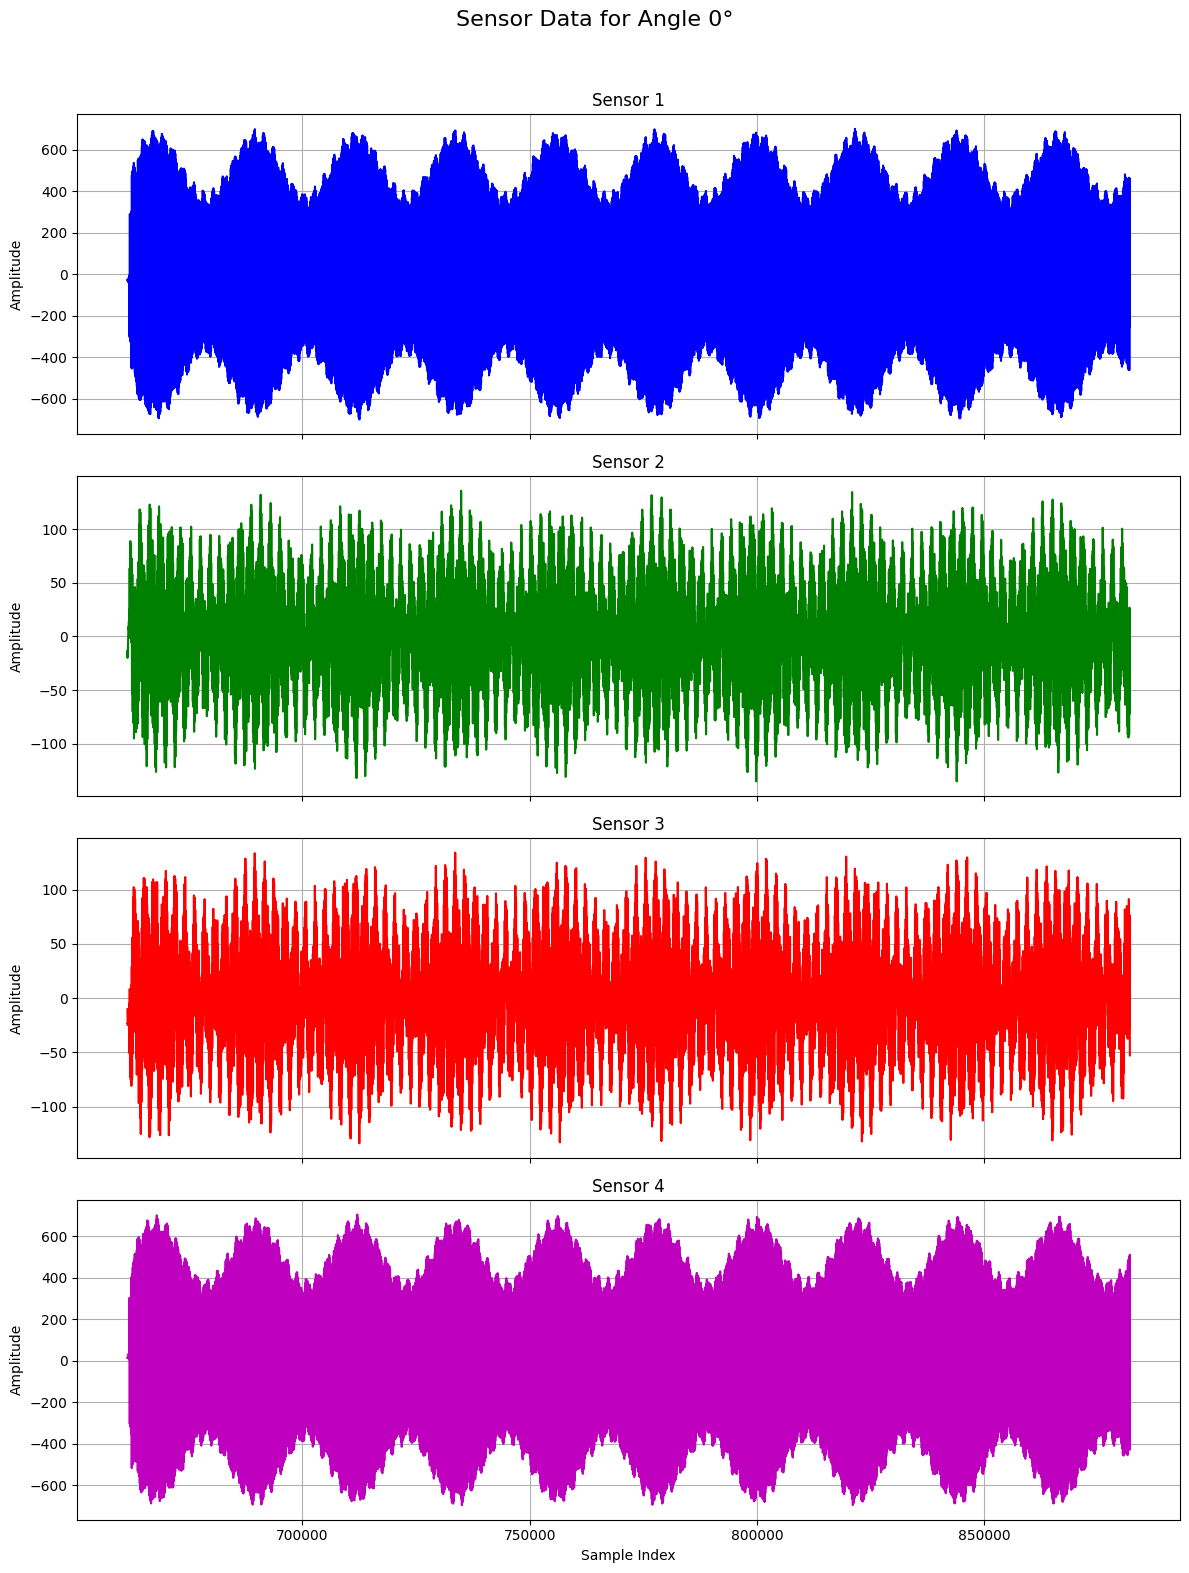

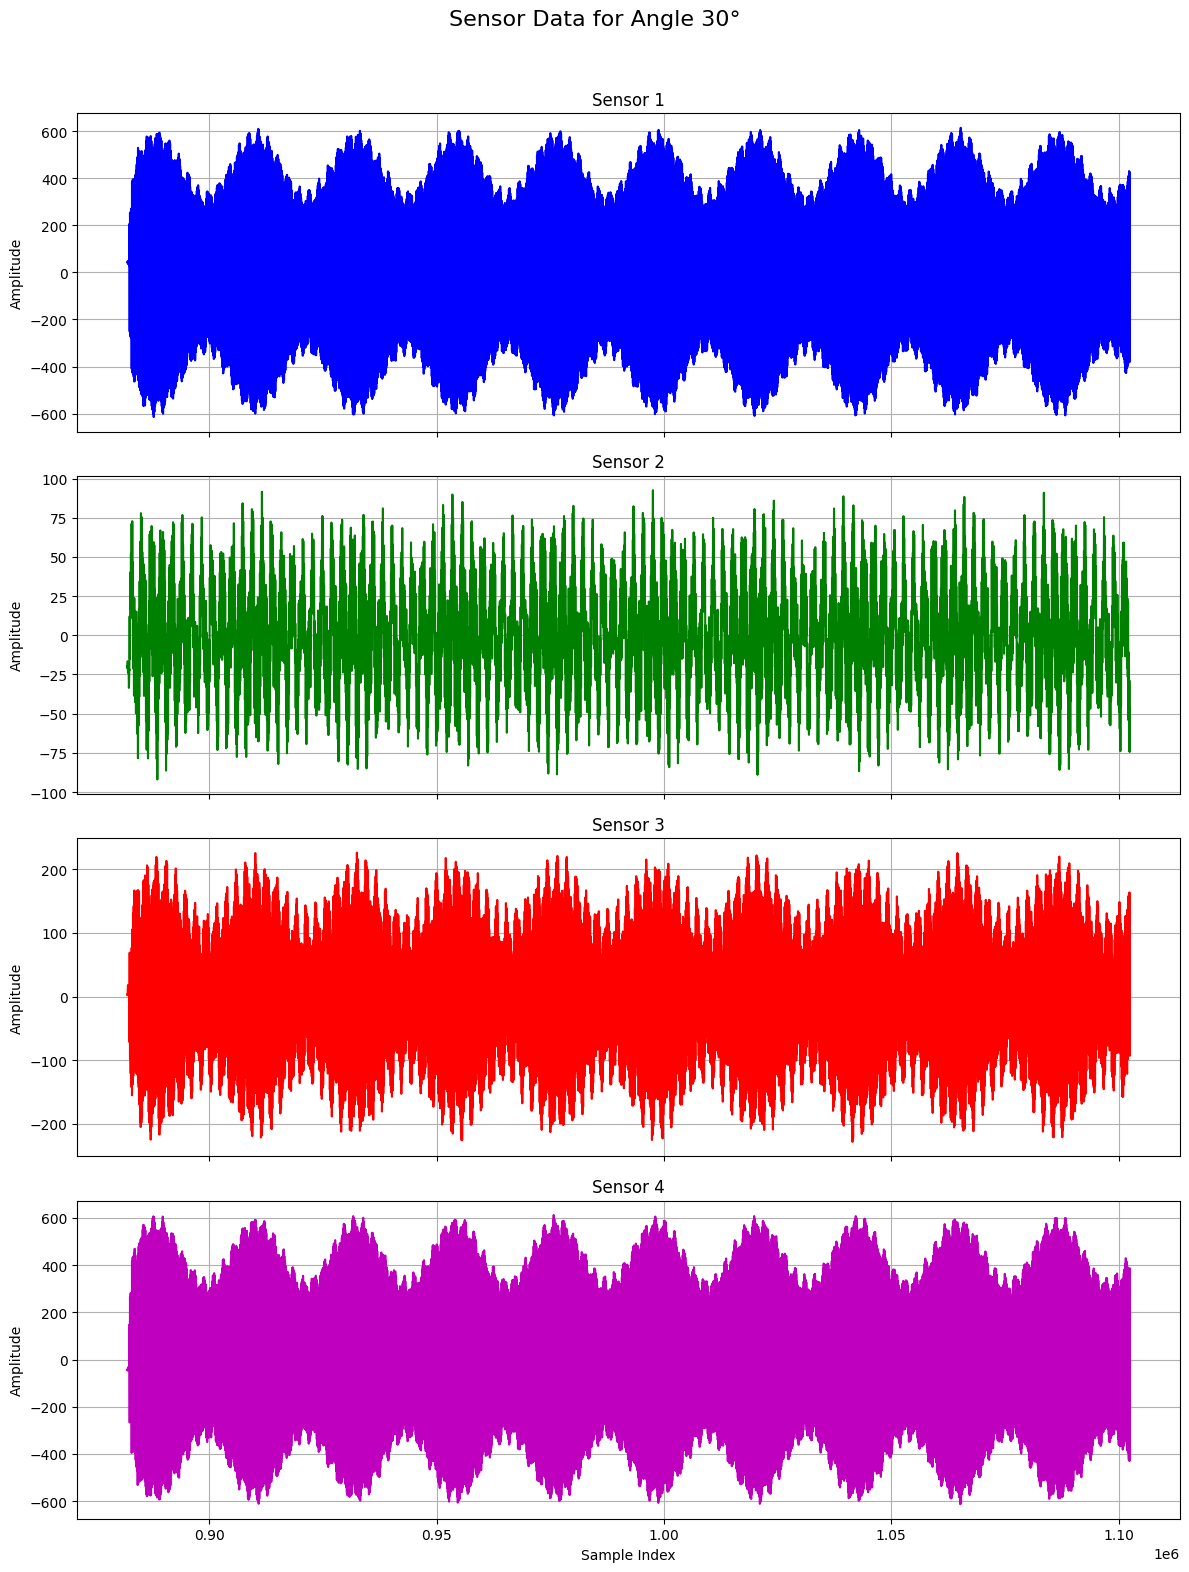

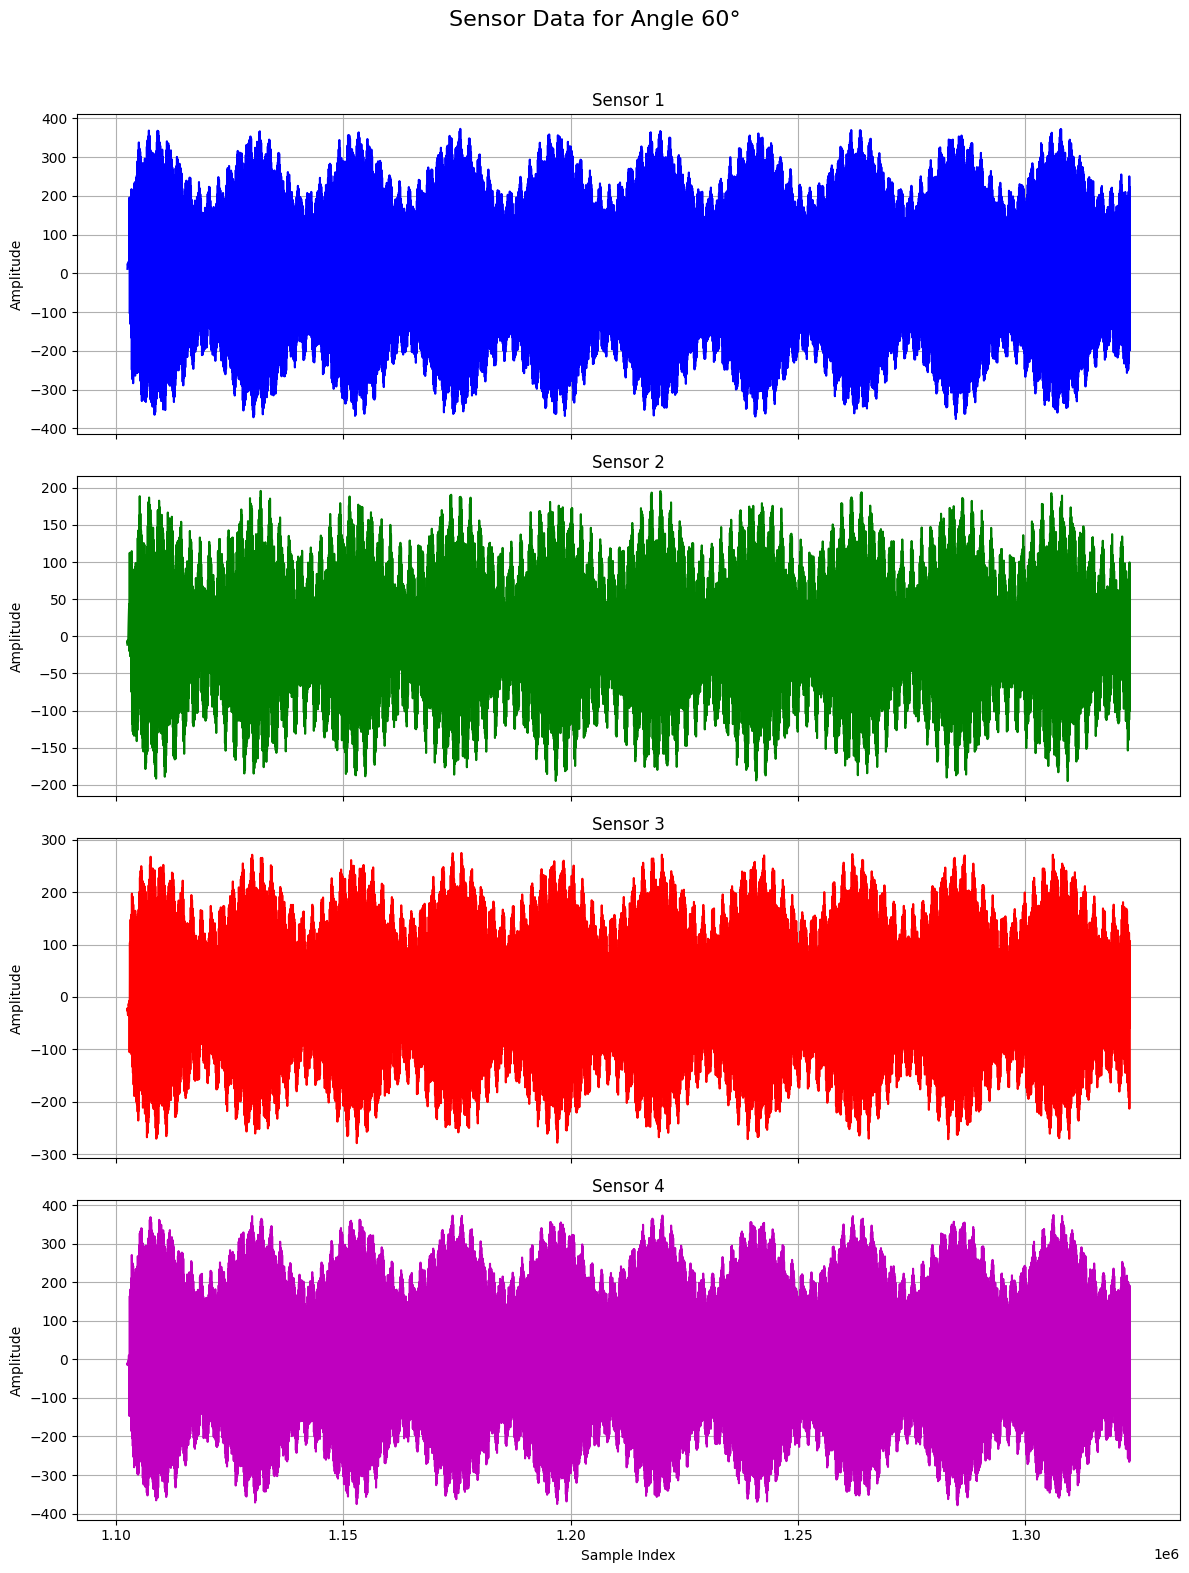

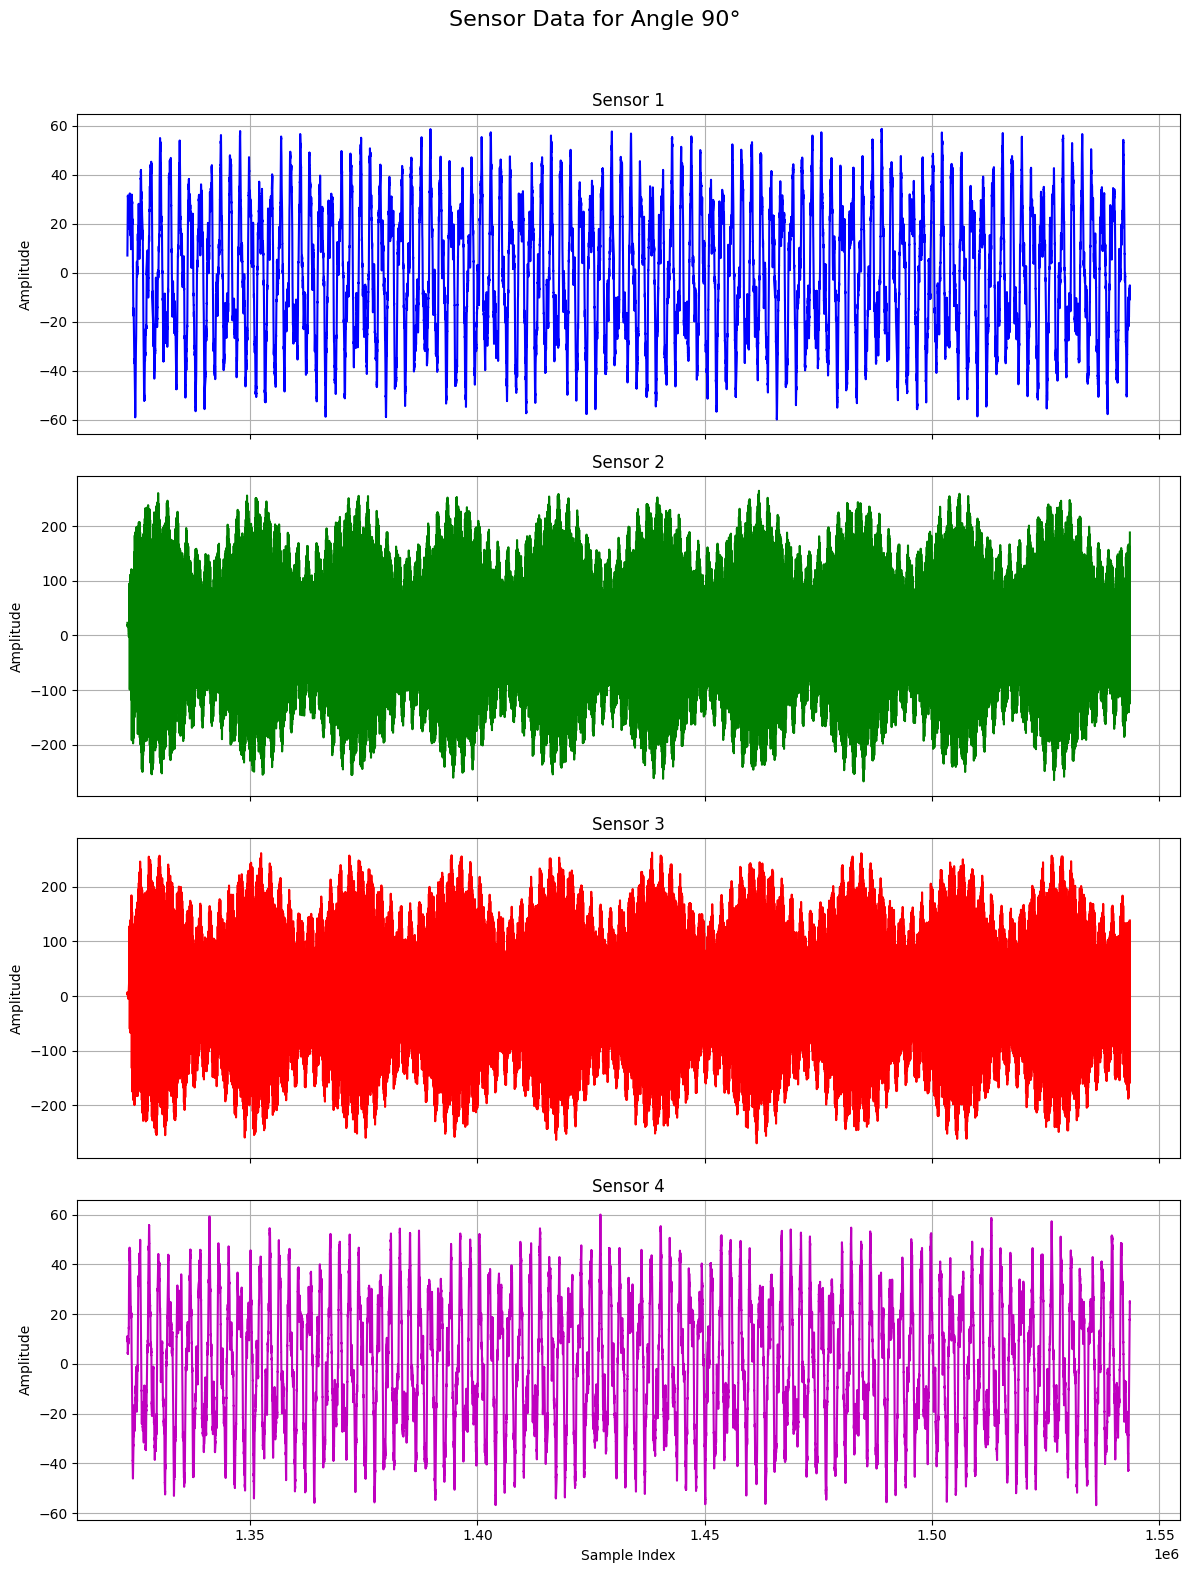

In [7]:
# Get unique angles
angles = combined_data['Angle'].unique()

# Plot all sensor data for each angle as subplots
for angle in angles:
    angle_data = combined_data[combined_data['Angle'] == angle]

    # Create a figure with subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
    fig.suptitle(f"Sensor Data for Angle {angle}°", fontsize=16)

    # Sensor 1
    axes[0].plot(angle_data.index, angle_data['Sensor1_Amplitude'], label='Sensor 1', color='b')
    axes[0].set_ylabel("Amplitude")
    axes[0].set_title("Sensor 1")
    axes[0].grid(True)

    # Sensor 2
    axes[1].plot(angle_data.index, angle_data['Sensor2_Amplitude'], label='Sensor 2', color='g')
    axes[1].set_ylabel("Amplitude")
    axes[1].set_title("Sensor 2")
    axes[1].grid(True)

    # Sensor 3
    axes[2].plot(angle_data.index, angle_data['Sensor3_Amplitude'], label='Sensor 3', color='r')
    axes[2].set_ylabel("Amplitude")
    axes[2].set_title("Sensor 3")
    axes[2].grid(True)

    # Sensor 4
    axes[3].plot(angle_data.index, angle_data['Sensor4_Amplitude'], label='Sensor 4', color='m')
    axes[3].set_xlabel("Sample Index")
    axes[3].set_ylabel("Amplitude")
    axes[3].set_title("Sensor 4")
    axes[3].grid(True)

    # Adjust layout and show
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [8]:
combined_data

,Angle,Sensor1_Amplitude,Sensor2_Amplitude,Sensor3_Amplitude,Sensor4_Amplitude
0,-90,22.780104,-17.249069,-12.606639,-41.498911
1,-90,22.679163,-16.901954,-12.376279,-41.795590
2,-90,22.634873,-16.714519,-12.196835,-42.007852
3,-90,22.556999,-16.449281,-11.913535,-42.301547
4,-90,22.628875,-16.254822,-11.846440,-42.579261
...,...,...,...,...,...
1543495,90,-5.823169,183.455104,126.714418,25.107061
1543496,90,-6.019413,184.923882,130.044133,24.967514
1543497,90,-6.113310,186.275321,132.946361,24.933039
1543498,90,-6.190263,187.349378,135.743975,24.748203


In [ ]:
# Prepare features and target
X = combined_data[['Sensor1_Amplitude', 'Sensor2_Amplitude', 'Sensor3_Amplitude', 'Sensor4_Amplitude']]
y = combined_data['Angle']

In [ ]:
# Normalize features
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
y_norm = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

In [ ]:
# Build the DNN model
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.01),  # Leaky ReLU activation
    Dense(64),
    LeakyReLU(alpha=0.01),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(1, activation='linear')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

In [ ]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Mean Absolute Error (MAE): {mae}")

# Make predictions
y_pred_norm = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_norm).flatten()

In [ ]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test.shape, y_pred.shape

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1, label='Predicted vs True')
plt.xlabel("True Angle")
plt.ylabel("Predicted Angle")
plt.legend()
plt.title("DNN System Identification: True vs Predicted Angles")
plt.grid(True)
plt.show()

In [ ]:
# Save the model in TensorFlow SavedModel format
saved_model_path = "my_model"  # Folder where the model will be saved
model.save(saved_model_path)
print(f"Model saved in TensorFlow SavedModel format at: {saved_model_path}")

In [ ]:
# Save the model in TensorFlow SavedModel format
saved_model_path = "my_model"  # Folder where the model will be saved

# Load the model (example for verification)
model = load_model(saved_model_path)  # Load SavedModel
print("Loaded model from TensorFlow SavedModel format.")

In [ ]:
# Extract weights and biases as a list of Numpy arrays
weights_and_biases = model.get_weights()

In [ ]:
# Save weights and biases as a .npz file
np.savez("weights_and_biases.npz", *weights_and_biases)
print("Weights and biases saved to 'weights_and_biases.npz'.")

In [ ]:
# Calculate the metrics of the sound data
def calculate_snr(signal, noise):
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_thd(signal, sampling_rate):
    fft = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), d=1/sampling_rate)
    magnitude = np.abs(fft)
    
    # Find fundamental frequency (first peak)
    fundamental_idx = np.argmax(magnitude[1:]) + 1
    fundamental_power = magnitude[fundamental_idx] ** 2
    
    # Sum of harmonic powers (exclude fundamental)
    harmonic_power = np.sum(magnitude**2) - fundamental_power
    thd = np.sqrt(harmonic_power) / fundamental_power
    return thd

def calculate_spectral_flatness(signal):
    spectrum = np.abs(np.fft.fft(signal))
    geometric_mean = np.exp(np.mean(np.log(spectrum + 1e-10)))  # Avoid log(0)
    arithmetic_mean = np.mean(spectrum)
    spectral_flatness = geometric_mean / arithmetic_mean
    return spectral_flatness

def calculate_spl(signal, reference_pressure=20e-6):
    signal_rms = np.sqrt(np.mean(signal**2))
    spl = 20 * np.log10(signal_rms / reference_pressure)
    return spl

def calculate_crest_factor(signal):
    peak_amplitude = np.max(np.abs(signal))
    rms = np.sqrt(np.mean(signal**2))
    crest_factor = peak_amplitude / rms
    return crest_factor

def calculate_skewness_kurtosis(signal):
    skewness = skew(signal)
    kurt = kurtosis(signal)
    return skewness, kurt

def calculate_dynamic_range(signal):
    dynamic_range = np.max(signal) - np.min(signal)
    return dynamic_range

In [ ]:
# Example signal and noise
sampling_rate = 44100  # Hz
signal = combined_data['Sensor1_Amplitude'][:44100]  # 1 second of data
noise = np.random.normal(0, 0.1, len(signal))  # Example noise

# Compute metrics
snr = calculate_snr(signal, noise)
thd = calculate_thd(signal, sampling_rate)
spectral_flatness = calculate_spectral_flatness(signal)
spl = calculate_spl(signal)
crest_factor = calculate_crest_factor(signal)
skewness, kurt = calculate_skewness_kurtosis(signal)
dynamic_range = calculate_dynamic_range(signal)

In [ ]:
# Display metrics
print(f"SNR: {snr} dB")
print(f"THD: {thd}")
print(f"Spectral Flatness: {spectral_flatness}")
print(f"SPL: {spl} dB")
print(f"Crest Factor: {crest_factor}")
print(f"Skewness: {skewness}, Kurtosis: {kurt}")
print(f"Dynamic Range: {dynamic_range}")

In [ ]:
# Normalize Metrics
def normalize_metric(values):
    """Normalize a list of values to the range [0, 1]."""
    return (values - np.min(values)) / (np.max(values) - np.min(values))

# Objective Function
def objective_function(angle_array, combined_data, metric_functions, metric_weights):
    """
    Minimize combined metric differences across sensors for a given angle.
    """
    angle = angle_array[0]  # Extract the scalar angle

    # Use approximate matching for angles
    tolerance = 1e-5
    angle_data = combined_data[np.isclose(combined_data['Angle'], angle, atol=tolerance)]

    # Ensure there is data for the current angle
    if angle_data.empty:
        return np.inf  # Return a large loss if no data is available

    # Calculate metrics for each sensor
    metrics = {metric: [] for metric in metric_functions}
    for sensor in ['Sensor1_Amplitude', 'Sensor2_Amplitude', 'Sensor3_Amplitude', 'Sensor4_Amplitude']:
        for metric_name, metric_func in metric_functions.items():
            metrics[metric_name].append(metric_func(angle_data[sensor].values))

    # Normalize metrics
    normalized_metrics = {
        metric: normalize_metric(values)
        for metric, values in metrics.items()
    }

    # Combine metrics into a single loss
    loss = 0
    for metric_name, values in normalized_metrics.items():
        weight = metric_weights[metric_name]
        if metric_name in ['SNR', 'SPL']:  # Metrics to maximize
            values = -values  # Invert to minimize
        loss += weight * np.mean([(values[i] - values[j])**2
                                  for i in range(len(values))
                                  for j in range(i + 1, len(values))])
    return loss

# Metric Functions and Weights
metric_functions = {
    'SNR': calculate_snr,
    'THD': calculate_thd,
    'SPL': calculate_spl,
    'Spectral Flatness': calculate_spectral_flatness
}
metric_weights = {
    'SNR': 2.0,  # Maximize
    'THD': 0.5,  # Minimize
    'SPL': 2.0,  # Maximize
    'Spectral Flatness': 0.5  # Minimize
}

In [ ]:
# Differential Evolution Optimization
bounds = [(-90, 90)]  # Angle bounds
result_de = differential_evolution(
    func=objective_function,
    bounds=bounds,
    args=(combined_data, metric_functions, metric_weights),
    strategy='best1bin',
    maxiter=500,
    tol=1e-6,
    seed=42
)

print(f"Optimal Angle (Differential Evolution): {result_de.x[0]:.2f}°")
print(f"Objective Function Value: {result_de.fun:.4f}")

# L-BFGS-B Optimization (as fallback)
result_lbfgs = minimize(
    fun=objective_function,
    x0=[0.0],  # Initial guess as an array
    args=(combined_data, metric_functions, metric_weights),
    bounds=[(-90, 90)],
    method='L-BFGS-B'
)

print(f"Optimal Angle (L-BFGS-B): {result_lbfgs.x[0]:.2f}°")
print(f"Objective Function Value: {result_lbfgs.fun:.4f}")